# Hedonic Price Estimation

## Objectives
Develop a robust regression model for predicting house prices.

Implement effective outlier treatment of numerical variables and feature engineering techniques.

Explore and visualize data relationships through EDA (Exploratory Data Analysis).

Apply encoding methods for categorical variables.

Deploy the model and develop an estimation tool in Excel

In [33]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as fm
import matplotlib.mlab as mlab
import seaborn as sns
from scipy.stats import pearsonr, ttest_rel, spearmanr, kendalltau
import textwrap
%matplotlib inline

In [5]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [6]:
data = pd.read_csv(r"C:\Users\basde\Documents\GitHub\Synta2025\10_09_2025\Les 1-20250910\belgium_community_les1.csv", delimiter=';')


In [29]:
immo = data.copy

In [8]:
immocopy = data.copy()

In [9]:
immocopy.isnull().sum()

locality                 0
type of property         0
subtype of property    472
price                    0
sale type                0
number of rooms          0
area                     0
furnished                0
open fire                0
terrace                291
terrace area           291
number of facades        0
building state           0
dtype: int64

<Axes: xlabel='locality', ylabel='price'>

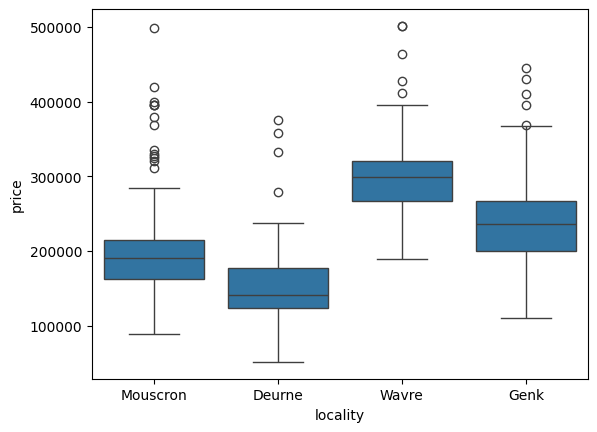

In [11]:
sns.boxplot(data=data, x="locality", y="price")

<Axes: xlabel='number of rooms', ylabel='price'>

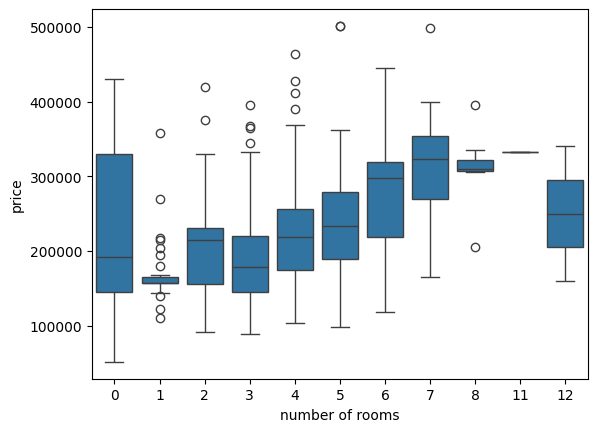

In [13]:
sns.boxplot(data=data, x="number of rooms", y="price")

<Axes: xlabel='building state', ylabel='price'>

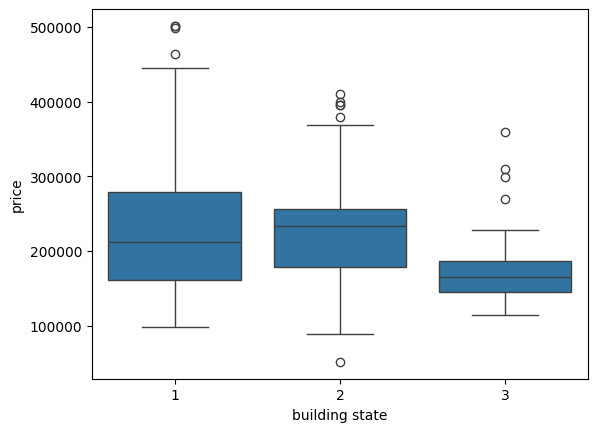

In [16]:
sns.boxplot(data=data, x="building state", y="price")

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   locality             534 non-null    object 
 1   type of property     534 non-null    object 
 2   subtype of property  62 non-null     object 
 3   price                534 non-null    int64  
 4   sale type            534 non-null    object 
 5   number of rooms      534 non-null    int64  
 6   area                 534 non-null    int64  
 7   furnished            534 non-null    int64  
 8   open fire            534 non-null    int64  
 9   terrace              243 non-null    object 
 10  terrace area         243 non-null    float64
 11  number of facades    534 non-null    int64  
 12  building state       534 non-null    int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 54.4+ KB


In [22]:
data[['furnished', 'terrace']].value_counts()

furnished  terrace
0          True       243
Name: count, dtype: int64

In [24]:
data[['furnished', 'terrace area']].value_counts()

furnished  terrace area
0          6.0             32
           10.0            23
           8.0             16
           20.0            12
           4.0             11
           5.0             10
           18.0             9
           50.0             9
           16.0             8
           9.0              8
           40.0             6
           14.0             6
           17.0             5
           23.0             5
           15.0             5
           30.0             4
           11.0             4
           66.0             4
           60.0             4
           22.0             4
           2.0              3
           12.0             3
           75.0             3
           90.0             3
           34.0             3
           13.0             3
           3.0              3
           24.0             3
           1.0              2
           55.0             2
           53.0             2
           45.0             2
           85.0 

In [19]:
numeric_cols = data.select_dtypes(include=np.number).columns

Text(0.5, 1.0, 'Pearson Correlation of Features')

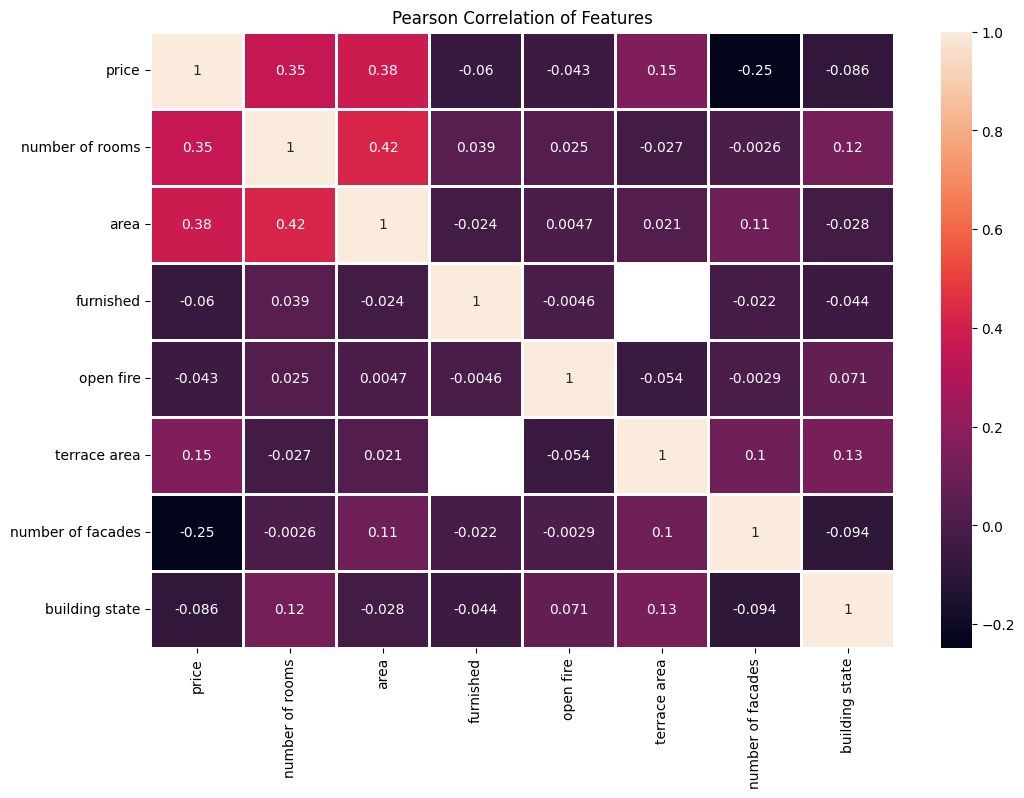

In [20]:
corr = data[numeric_cols].corr()
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(corr, annot=True, square=False, ax=ax, linewidth = 1)
plt.title('Pearson Correlation of Features')

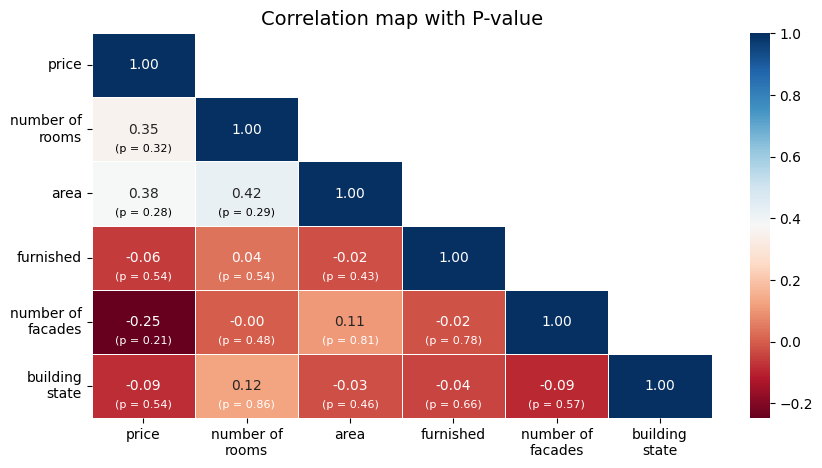

In [34]:
# Generate the correlation matrix afresh
corr = data[['price','number of rooms','area','furnished','number of facades','building state']].corr()
# mask the correlation matrix to diagonal
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
np.fill_diagonal(mask, False)
fix,ax = plt.subplots(figsize=(10,5))
plt.title("Correlation map with P-value", fontsize=14)
# Generate heatmap
heatmap = sns.heatmap(corr,
annot= True,
annot_kws={"fontsize": 10},
fmt='.2f',
linewidths=0.5,
cmap='RdBu',
mask=mask,
ax=ax)

# calculate and format p-values
p_values = np.full((corr.shape[0], corr.shape[1]), np.nan)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[1]):
        x = corr.iloc[:, i]
        y = corr.iloc[:, j]
        mask = ~np.logical_or(np.isnan(x), np.isnan(y))
        if np.sum(mask) > 0:
            p_values[i, j] = pearsonr(x[mask], y[mask])[1] #change to kendalltau or spearmanr
            
# Create a dataframe object for p_values
p_values = pd.DataFrame(p_values, columns=corr.columns, index=corr.index)
# Mask the p values
mask_pvalues = np.triu(np.ones_like(p_values), k=1)
# Generate maximum and minimum correlation coefficients for p-value annotation color
max_corr = np.max(corr.max())
min_corr = np.min(corr.min())
# Assign p-value annotations, include asterisks for significance
for i in range (p_values.shape[0]):
    for j in range(p_values.shape[1]):
        if mask_pvalues[i, j]:
            p_value = p_values.iloc[i, j]
            if not np.isnan(p_value):
                correlation_value = corr.iloc[i, j]
                text_color = 'white' if correlation_value >= (max_corr - 0.4) or correlation_value <= (min_corr + 0.4) else 'black'
                if p_value <= 0.01:
                    #include double asterisks for p-value <= 0.01
                    ax.text(i + 0.5, j + 0.8, f'(p = {p_value:.2f})**',
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=8,
                    color=text_color)
                elif p_value <= 0.05:
                #include single asterisk for p-value <= 0.05
                    ax.text(i + 0.5, j + 0.8, f'(p = {p_value:.2f})*',
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=8,
                    color=text_color)
                else:
                    ax.text(i + 0.5, j + 0.8, f'(p = {p_value:.2f})',
                    horizontalalignment='center',
                    verticalalignment='center',
                    fontsize=8,
                    color=text_color)

# Customize x-axis labels
x_labels = [textwrap.fill(label.get_text(), 13) for label in ax.get_xticklabels()]
ax.set_xticklabels(x_labels, rotation=0, ha="center")
# Customize y-axis labels
y_labels = [textwrap.fill(label.get_text(), 13) for label in ax.get_yticklabels()]
ax.set_yticklabels(y_labels, rotation=0, ha="right")
# Display the plot
plt.show()

In [37]:
#select predictor variables
x = data[['area','number of facades','building state']]
#select response variable
y = data["price"]
#define response variable
y = y
#define predictor variables
x = x
#add constant to predictor variables
x = sm.add_constant(x)
#fit linear regression model
model = sm.OLS(y, x).fit()
#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.239
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     55.59
Date:                Wed, 10 Sep 2025   Prob (F-statistic):           2.95e-31
Time:                        19:41:02   Log-Likelihood:                -6685.1
No. Observations:                 534   AIC:                         1.338e+04
Df Residuals:                     530   BIC:                         1.340e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               2.34e+05   1.14e+0

In [49]:
data = pd.get_dummies(data, columns = ['locality'])
data.head()

,type of property,subtype of property,price,sale type,number of rooms,area,furnished,open fire,terrace,terrace area,number of facades,building state,locality_Deurne,locality_Genk,locality_Mouscron,locality_Wavre
0,Appartement,NaN,204584,notariale,2,4,0,0,True,40.0,2,2,False,False,True,False
1,Appartement,NaN,395000,notariale,6,212,0,0,NaN,NaN,2,1,False,False,True,False
2,Appartement,NaN,182500,notariale,2,50,0,0,NaN,NaN,2,1,False,False,True,False
3,Appartement,NaN,229500,notariale,2,70,0,0,NaN,NaN,2,1,False,False,True,False
4,Appartement,NaN,239500,notariale,3,50,0,0,NaN,NaN,2,1,False,False,True,False


In [53]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   type of property     534 non-null    object 
 1   subtype of property  62 non-null     object 
 2   price                534 non-null    int64  
 3   sale type            534 non-null    object 
 4   number of rooms      534 non-null    int64  
 5   area                 534 non-null    int64  
 6   furnished            534 non-null    int64  
 7   open fire            534 non-null    int64  
 8   terrace              243 non-null    object 
 9   terrace area         243 non-null    float64
 10  number of facades    534 non-null    int64  
 11  building state       534 non-null    int64  
 12  locality_Deurne      534 non-null    bool   
 13  locality_Genk        534 non-null    int64  
 14  locality_Mouscron    534 non-null    int64  
 15  locality_Wavre       534 non-null    int

In [46]:
immo_dummy[['area','number of facades','building state','locality_Deurne','locality_Genk','locality_Mouscron','locality_Wavre']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   area               534 non-null    int64
 1   number of facades  534 non-null    int64
 2   building state     534 non-null    int64
 3   locality_Deurne    534 non-null    bool 
 4   locality_Genk      534 non-null    bool 
 5   locality_Mouscron  534 non-null    bool 
 6   locality_Wavre     534 non-null    bool 
dtypes: bool(4), int64(3)
memory usage: 14.7 KB


In [55]:
data[['locality_Deurne', 'locality_Genk','locality_Mouscron','locality_Wavre']] = data[['locality_Deurne', 'locality_Genk','locality_Mouscron','locality_Wavre']].astype(int)

In [56]:
x = data[['area','number of facades','building state','locality_Deurne','locality_Genk','locality_Mouscron','locality_Wavre']]
y = data["price"]
import statsmodels.api as sm
#define response variable
y = y
#define predictor variables
x = x
#add constant to predictor variables
x = sm.add_constant(x)
#fit linear regression model
model = sm.OLS(y, x).fit()
#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.520
Method:                 Least Squares   F-statistic:                     97.23
Date:                Wed, 10 Sep 2025   Prob (F-statistic):           5.04e-82
Time:                        19:55:07   Log-Likelihood:                -6559.2
No. Observations:                 534   AIC:                         1.313e+04
Df Residuals:                     527   BIC:                         1.316e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.342e+05   7967.21

In [47]:
data['price'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 534 entries, 0 to 533
Series name: price
Non-Null Count  Dtype
--------------  -----
534 non-null    int64
dtypes: int64(1)
memory usage: 4.3 KB


In [48]:
np.asarray(immo_dummy[['area','number of facades','building state','locality_Deurne','locality_Genk','locality_Mouscron','locality_Wavre']])

array([[4, 2, 2, ..., False, True, False],
       [212, 2, 1, ..., False, True, False],
       [50, 2, 1, ..., False, True, False],
       ...,
       [40, 1, 2, ..., True, False, False],
       [55, 2, 1, ..., True, False, False],
       [200, 2, 1, ..., True, False, False]], dtype=object)